# 케라스 모델을 만드는 방법
##### Sequential model | Functional API model | Subclassing model | 혼합 모델

## 0. 라이브러리

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import layers, models, callbacks

## 1. Sequential model

### 1.1-1 Sequential class

In [2]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

### 1.1-2 점진적 Sequential
- add()

In [3]:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

### 1.2 모델 호출
- 가중치를 만들기 위함

In [4]:

model.build(input_shape=(None, 3)) # 입력데이터의 차원 = 배치크기:유동적 / 입력데이터의 특징:(3,)
model.weights                      # 모델의 가중치 확인

[<KerasVariable shape=(3, 64), dtype=float32, path=sequential_1/dense_2/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=sequential_1/dense_2/bias>,
 <KerasVariable shape=(64, 10), dtype=float32, path=sequential_1/dense_3/kernel>,
 <KerasVariable shape=(10,), dtype=float32, path=sequential_1/dense_3/bias>]

### 1.3 모델 요약

In [5]:

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

- 각 층의 출력 형태 : (None, 64) , (None, 10)
- 첫 층의 파라미터 : (입력차원3*출력차원64)+바이어스64 = 256
- 두번째 층의 파라미터 : (입력차원64*출력차원10)+바이어스10 = 650
- Total 파라미터 : 256 + 650 = 906
- Trainable 파라미터 : 훈련가능한 파라미터 수 = 906 | Non-trainable = 0

### 1.4 모델과 층에 이름 지정
- name 매개변수

In [21]:

model = keras.Sequential(name="my_example_model")                       # 모델 이름
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))   # 1층 이름
model.add(layers.Dense(10, activation="softmax", name="my_last_layer")) # 2층 이름
model.build((None, 3))
model.summary()

Model: "my_example_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_first_layer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_last_layer (Dense)           │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

- Sequential 모델을 점진적으로 만들 때, build() 후에 summary() 호출 가능

### 1.5 모델의 입력크기 미리 지정
- Sequential 모델의 가중치를 바로 생성

In [24]:
model = keras.Sequential()
model.add(keras.Input(shape=(3,))) # 각 샘플의 크기
model.add(layers.Dense(64, activation="relu"))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 64)             │           256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256 (1.00 KB)

 Trainable params: 256 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

## 2. Functional API model
- 다중입력(이미지, 메타데이터), 다중출력(여러가지 항목 예측), 비선형적인구조 모델
- 블럭처럼 쌓는 방식

### 2.1 functional api model

In [25]:
inputs = keras.Input(shape=(3,), name="my_input")      # 이모델은 각 샘플의 크기가 (3,)인 배치를 처리할 것. 단 배치 크기는 유동적
features = layers.Dense(64, activation="relu")(inputs) # inputs을 받아 64개의 유닛으로 출력(64차원)을 features에 저장
outputs = layers.Dense(10, activation="softmax")(features) # features를 받아 10개의 유닛으로 출력(10차원)을 outputs에 저장
model = keras.Model(inputs=inputs, outputs=outputs)        # 모델정의
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_input (InputLayer)           │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

### 2.2 다중입력, 다중출력 모델 정의

In [26]:
# 입력 정의
vocabulary_size = 10000
num_tags = 100
num_departments = 4
title = keras.Input(shape=(vocabulary_size,), name="title")         # 입력텐서: 크기(10000,)벡터
text_body = keras.Input(shape=(vocabulary_size,), name="text_body") # 입력텐서: 크기(10000,)벡터
tags = keras.Input(shape=(num_tags,), name="tags")                  # 입력텐서: 크기(100,)벡터
# 특징결합, Dense층
features = layers.Concatenate()([title, text_body, tags])           # 특징결합: 크기(20100)벡터
features = layers.Dense(64, activation="relu")(features)            # Dense층: 64차원 벡터로 변환
# 출력 정의
priority = layers.Dense(1, activation="sigmoid", name="priority")(features) # 출력= 1개 (중요도: 0~1사이 확률)
department = layers.Dense(
    num_departments, activation="softmax", name="department")(features) # 출력= 4개 (각 부서에 속할 확률)
# 모델 정의
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department]) # 모델 정의

### 2.3 다중입력, 다중출력 모델 훈련
- 모델 컴파일, 모델훈련, 모델평가, 예측

In [11]:
# 데이터 생성
import numpy as np

num_samples = 1280
## 입력데이터
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))      # 제목데이터: (1280,10000)크기 (0,2] 
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))  # 본문데이터: (1280,10000)크기 (0,2]
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))              # 태그데이터: (1280,100)크기 (0,2]
## 타킷데이터
priority_data = np.random.random(size=(num_samples, 1))                        # 중요도데이터: (1280,1) 크기의 랜덤 실수
department_data = np.random.randint(0, 2, size=(num_samples, num_departments)) # 부서데이터: (1280,4) 크기
# 모델컴파일
model.compile(optimizer="rmsprop", # 최적화 알고리즘
              loss=["mean_squared_error", "categorical_crossentropy"], # 손실함수: 첫출력(priority)/두번째출력(department) 사용
              metrics=[["mean_absolute_error"], ["accuracy"]])         # 척도: 첫출력(priority)/두번째출력(department) 사용
# 모델훈련
model.fit([title_data, text_body_data, tags_data],      # 입력데이터
          [priority_data, department_data],             # 출력데이터
          epochs=1) # 1회 반복
# 모델평가
model.evaluate([title_data, text_body_data, tags_data], # 평가에 사용할 입력데이터
               [priority_data, department_data])        # 평가에 사용할 출력데이터
# 예측수행
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data]) 

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - department_accuracy: 0.2155 - loss: 36.1988 - priority_mean_absolute_error: 0.4629
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - department_accuracy: 0.0746 - loss: 29.8740 - priority_mean_absolute_error: 0.4938
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### 2.4 다중입력, 다중출력 모델 훈련 (+딕셔너리)
- 모델 정의(2.2)에서 사용된 Input객체와 출력층에 부여한 이름 활용
- 입력순서에 신경쓰지 않음

In [27]:
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data},
          epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
               {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - department_accuracy: 0.2584 - loss: 23.4038 - priority_mean_absolute_error: 0.4843
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - department_accuracy: 0.1148 - loss: 21.7321 - priority_mean_absolute_error: 0.5062 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### 2.5 특성추출 모델생성
### 2.5-1 특성추출
- model.layers : 모든 층의 정보 리스트
- model.layers[i] : 해당 층의 정보
  - model.layers[3].input : 4번째 층(Concatenate)의 입력 정보
  - model.layers[3].output : 4번째 층의 출력 정보

In [42]:
model.layers

[<InputLayer name=title, built=True>,
 <InputLayer name=text_body, built=True>,
 <InputLayer name=tags, built=True>,
 <Concatenate name=concatenate_1, built=True>,
 <Dense name=dense_17, built=True>,
 <Dense name=priority, built=True>,
 <Dense name=department, built=True>]

### 2.5-2 특성추출 모델생성
- input: title, text_body, tags
- output: priority, department, difficulty

In [44]:
# 새로운 Dense층
features = model.layers[4].output # = layers.Dense(64, activation="relu")(features)  
# 새로운 출력정의
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)
# 새로운 모델정의
new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty])

## 3. Subclassing model
- init: 메서드에서 모델이 사용할 층 정의
- call() : 메서드에서 앞서 만든 층을 사용하여 모델의 정방향 패스를 정의
- 서브클래스의 객체를 만들고 데이터와 함께 호출하여 가중치를 만듦

### 3.1 서브캘르싱 모델

In [17]:
# 클래스 정의와 초기화
class CustomerTicketModel(keras.Model): # keras의 Model 클래스 상속
    # 모델이 사용할 층 정의
    def __init__(self, num_departments): 
        super().__init__() # 부모 클래스의 초기화 작업
        self.concat_layer = layers.Concatenate() # 입력텐서들 결합 층
        self.mixing_layer = layers.Dense(64, activation="relu") # 64개의 유닛을 가진 Dense층
        self.priority_scorer = layers.Dense(1, activation="sigmoid") # 1개의 유닛을 가진 Dense층 (우선순위 예측)
        self.department_classifier = layers.Dense( 
            num_departments, activation="softmax") # 부서를 예측하는 Dense층 ()
    # 모델의 정방향 패스를 정의
    def call(self, inputs):
        # 입력
        title = inputs["title"]         # 제목입력 텐서를 가져옴
        text_body = inputs["text_body"] # 본문입력 텐서를 가져옴
        tags = inputs["tags"]           # 태그입력 텐서를 가져옴
        # 특징결합, Dense층
        features = self.concat_layer([title, text_body, tags]) # 3개의 입력텐서를 결합
        features = self.mixing_layer(features) # 64개의 유닛을 가진 Dense층 통과
        # 출력
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department # 우선순위, 부서예측 값 반환

## 4. 혼합모델
- 다른 종류의 모델간 상호 운영 가능

### 4.1 서브클래싱한 모델을 포함하는 함수형 모델

In [18]:
class Classifier(keras.Model): # keras.Model 상속

    def __init__(self, num_classes=2):
        super().__init__() # 부모클래스 초기화
        if num_classes == 2:
            num_units = 1 # Dense층의 유닛 수: 1
            activation = "sigmoid"
        else:
            num_units = num_classes # Dense층의 유닛 수: class 수
            activation = "softmax"
        # Dense층 정의
        self.dense = layers.Dense(num_units, activation=activation)
    # 출력 생성
    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,)) # 입력텐서
features = layers.Dense(64, activation="relu")(inputs) 
outputs = Classifier(num_classes=10)(features) # 출력텐서-Classifier에서 else의 다중분류 수행
model = keras.Model(inputs=inputs, outputs=outputs) # 최종 모델

### 4.2 함수형 모델을 포함하는 서브클래싱 모델

In [7]:
# 함수형 이진분류 모델정의
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)
# 사용자 정의 모델
class MyModel(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier # 함수형모델 사용 최종 출력생성

    def call(self, inputs):
        features = self.dense(inputs) 
        return self.classifier(features) # 이진분류모델을 통해 최종 븐류 결과 출력

model = MyModel()

In [6]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8660 - loss: 0.4456 - val_accuracy: 0.9576 - val_loss: 0.1450
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9507 - loss: 0.1676 - val_accuracy: 0.9654 - val_loss: 0.1276
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9625 - loss: 0.1325 - val_accuracy: 0.9721 - val_loss: 0.1015
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.9704 - loss: 0.1136
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step


### 사용자 정의 지표

In [16]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [18]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8607 - loss: 0.4611 - val_accuracy: 0.9594 - val_loss: 0.1435
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9502 - loss: 0.1720 - val_accuracy: 0.9679 - val_loss: 0.1173
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9622 - loss: 0.1379 - val_accuracy: 0.9707 - val_loss: 0.1140
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9686 - loss: 0.1140 - val_accuracy: 0.9722 - val_loss: 0.1031
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9717 - loss: 0.1033 - val_accuracy: 0.9759 - val_loss: 0.0951
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9738 - loss: 0.0923 - val_accuracy: 0.9781 - val_loss: 0.0903
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9749 - loss: 0.0878 - val_accuracy: 0.9774 - val_loss: 0.1001
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9785 - loss: 0.0789 - 

In [19]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

#### 회고
: 모델을 만드는 여러 방법이 있는 것을 알게되었고

서로 사용하는 목적에 따라 다양하게 쓸 수 있음을 알게되었습니다.

1조:레이어 개수가 늘어나면서 수렴을 빨리한다!?
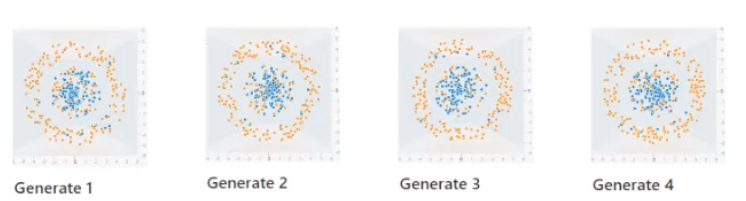

2조: 레이어 두단계부터는 맥스와 결과가 비슷하다!

3조:relu와 tanh sigmoid의 속도 비교를 했던 점이 흥미롭고 궁금하다
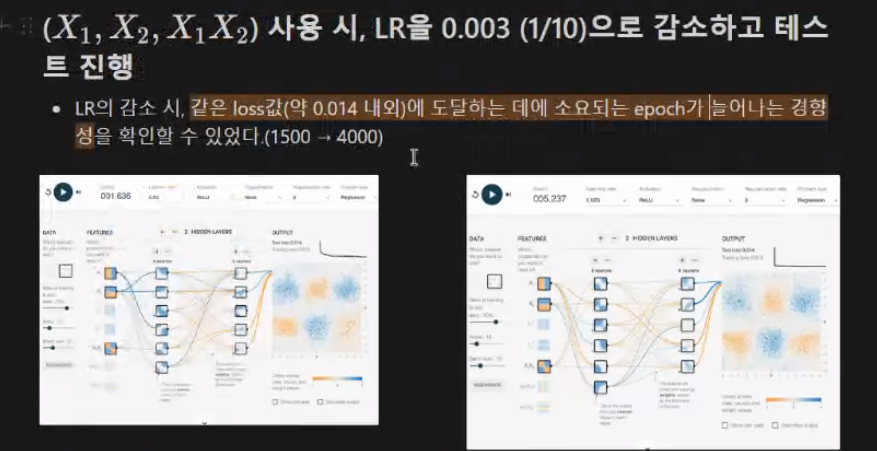

4조: activation와 droput rate를 다르게 나눠 진행
relu, 0.8으로 설정했을때 val_acc가 갑자기 증가하는 그래프가 이상하고 이유 궁금했다.

5조: 

6조: convolution layer의 필터를 변경해 차이를 비교했다

7조: 우리조, conv를 두번 쓴 층에서 더 잘 학습하지만 과적합의 문제가 있을것 같았다.

8조: layer의 깊이 변화 conv-max : conv-max반복. dense층을 늘리니 효과가 더 안좋아 질 수 있다!